## Setup

In [48]:
import mne
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import CSP
import scipy.io
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt

## Parameters

In [49]:
subject_id = 1
t_start = 0.5
t_end = 2.5
n_ica_components = 15

## Load data

In [50]:
raw = mne.io.read_raw_gdf(f'./data/train/A0{subject_id}T.gdf', preload=True)

eog_channels = [ch for ch in raw.ch_names if 'EOG' in ch]

raw.set_channel_types({ch: 'eog' for ch in eog_channels})

raw = raw.pick_types(eeg=True, eog=False)

print(raw.info)

Extracting EDF parameters from /home/dyxcvi/Documents/UCM/experiments/exp#1/data/train/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/usr/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
<Info | 8 non-empty values
 bads: []
 ch_names: EEG-Fz, EEG-0, EEG-1, EEG-2, EEG-3, EEG-4, EEG-5, EEG-C3, EEG-6, ...
 chs: 22 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 2005-01-17 12:00:00 UTC
 nchan: 22
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: A01, sex: 0, last_name: X, birthday: 1983-01-17>
>


In [51]:
events, event_id = mne.events_from_annotations(raw)

event_id

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


{'1023': 1,
 '1072': 2,
 '276': 3,
 '277': 4,
 '32766': 5,
 '768': 6,
 '769': 7,
 '770': 8,
 '771': 9,
 '772': 10}

## Create epochs

### Divide

In [52]:
event_dict = {
    'left_hand':    event_id['769'], 
    'right_hand':   event_id['770'], 
    'feet':         event_id['771'], 
    'tongue':       event_id['772']
    }

epochs = mne.Epochs(
    raw, 
    events, 
    event_id=event_dict,
    tmin=t_start, tmax=t_end,
    baseline=None, 
    preload=True,
)

Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 501 original time points ...
0 bad epochs dropped


### Filter

In [53]:
epochs.filter(l_freq=8.0, h_freq=30.0)

Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



<Epochs | 288 events (all good), 0.5 – 2.5 s (baseline off), ~24.2 MiB, data loaded,
 'left_hand': 72
 'right_hand': 72
 'feet': 72
 'tongue': 72>

## Get features and labels

In [54]:
from sklearn.preprocessing import StandardScaler

X = epochs.get_data(picks='eeg') # Shape (n_trials, n_channels, n_samples)

y = epochs.events[:, 2] # The event IDs (e.g., 769, 770...)

In [55]:
np.max(X), np.min(X), np.std(X)

(4.222987530588521e-05, -4.207706561190561e-05, 5.336835862321985e-06)

In [56]:
len(y)

288

## Setup training pipeline

In [57]:
# 1. Set up the MNE/SKLearn pipeline
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
lda = LinearDiscriminantAnalysis()
clf = Pipeline([('CSP', csp), ('LDA', lda)])

In [59]:
# 5-fold cross-validation
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps * 22 dim * 7.4e+09  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.
Estimating class=9 covariance using EMPIRICAL
Done.
Estimating class=10 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps * 22 dim * 7.3e+09  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.
Estimating class=9 covariance using EMPIRICAL
Done.
Estimating class=10 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps

## Visualize data

Computing rank from data with rank=None
    Using tolerance 4e-05 (2.2e-16 eps * 22 dim * 8.3e+09  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.
Estimating class=9 covariance using EMPIRICAL
Done.
Estimating class=10 covariance using EMPIRICAL
Done.
Plotting 3D visualization...
Plot saved as 'lda_3d_visualization.png'


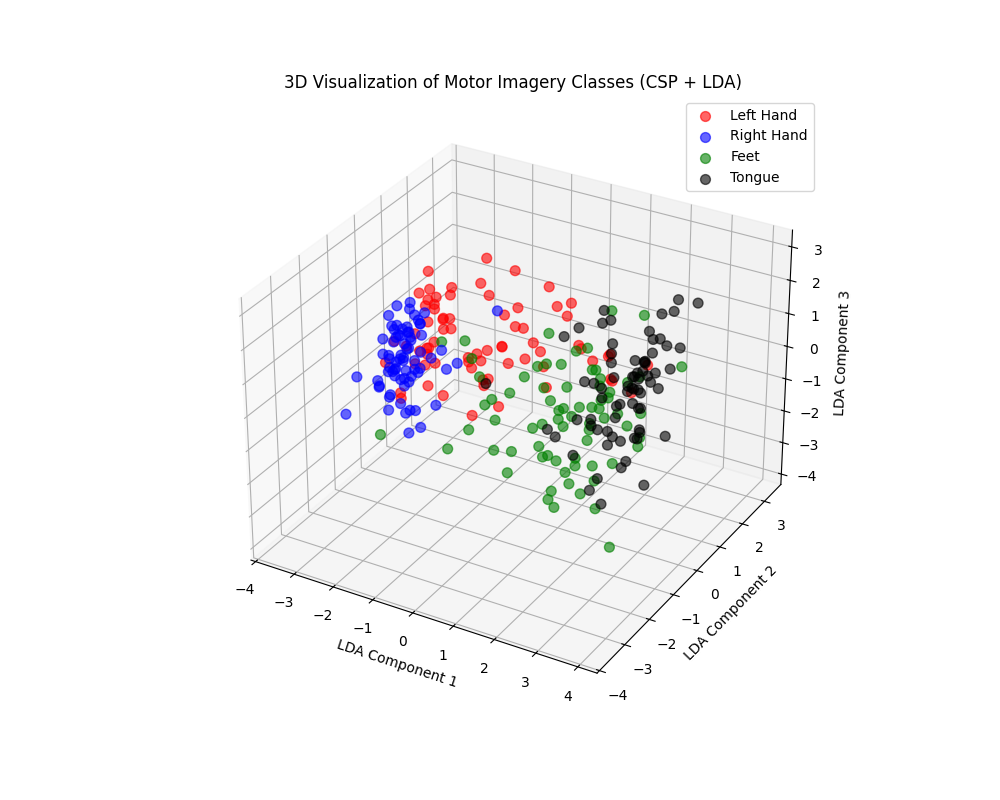

In [58]:
%matplotlib widget

# --- 1. Extract CSP Features ---
csp_viz = CSP(n_components=4, reg=None, log=True, norm_trace=False)
X_features = csp_viz.fit_transform(X, y)

# --- 2. Apply LDA for Dimensionality Reduction ---
lda_viz = LinearDiscriminantAnalysis(n_components=3)

# Fit and transform the CSP features.
# This finds the 3 best axes for separating the 4 classes.
X_3d = lda_viz.fit_transform(X_features, y)

# --- 3. Plot in 3D ---
print("Plotting 3D visualization...")

# Create the mapping from event ID to a name (for the legend)
label_names = {
    7: 'Left Hand',
    8: 'Right Hand',
    9: 'Feet',
    10: 'Tongue'
}
colors = {
    7: 'r',
    8: 'b',
    9: 'g',
    10: 'k'
}


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each class separately
for label_val, name in label_names.items():
    # Find the indices of all trials belonging to this class
    idx = (y == label_val)
    
    # Plot only those trials
    ax.scatter(
        X_3d[idx, 0],  # 1st component
        X_3d[idx, 1],  # 2nd component
        X_3d[idx, 2],  # 3rd component
        c=colors[label_val],
        label=name,
        s=50,          # marker size
        alpha=0.6
    )

ax.set_title('3D Visualization of Motor Imagery Classes (CSP + LDA)')
ax.set_xlabel('LDA Component 1')
ax.set_ylabel('LDA Component 2')
ax.set_zlabel('LDA Component 3')
ax.legend()
plt.savefig('lda_3d_visualization.png')

print("Plot saved as 'lda_3d_visualization.png'")

## Fit model

In [30]:
clf.fit(X, y)

print("Model trained!")

Computing rank from data with rank=None
    Using tolerance 4e-05 (2.2e-16 eps * 22 dim * 8.3e+09  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.
Estimating class=9 covariance using EMPIRICAL
Done.
Estimating class=10 covariance using EMPIRICAL
Done.
Model trained!


## Evaluate

### Load eval data

In [31]:
raw_eval = mne.io.read_raw_gdf(f'./data/eval/A0{subject_id}E.gdf', preload=True)

events_eval, event_id_eval = mne.events_from_annotations(raw_eval)

print(event_id_eval)

Extracting EDF parameters from /home/dyxcvi/Documents/UCM/experiments/exp#1/data/eval/A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 686999  =      0.000 ...  2747.996 secs...


/usr/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
{'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '783': 7}


### Process eval data

In [32]:
# 1. Set channel types (same as before)
eog_channels_eval = [ch for ch in raw_eval.ch_names if 'EOG' in ch]
raw_eval.set_channel_types({ch: 'eog' for ch in eog_channels_eval})

# Discard EOG channels
raw_eval = raw_eval.pick_types(eeg=True, eog=False)

# 3. Get events
events_eval, event_id_eval = mne.events_from_annotations(raw_eval)

# 4. Define the event dictionary
# We assume the event codes (e.g., '769') are the same
event_dict_eval = {
    'unknown_cue': event_id_eval['783']
}

# 5. Create epochs
epochs_eval = mne.Epochs(
    raw_eval,
    events_eval, 
    event_id=event_dict_eval,
    tmin=0.0, tmax=4.0,
    baseline=None,  
    preload=True
)

# 6. Filter
epochs_eval.filter(l_freq=8.0, h_freq=30.0)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '783']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



<Epochs | 288 events (all good), 0 – 4 s (baseline off), ~48.4 MiB, data loaded,
 'unknown_cue': 288>

### Extract features

In [33]:
# Get the preprocessed evaluation data
X_eval = epochs_eval.get_data()

In [63]:
X_eval.shape

(288, 22, 1001)

### Load true labels

In [34]:
# Load the .mat file
# Replace 'A0XE.mat' with your actual file path (e.g., 'A01E.mat')
mat_labels = scipy.io.loadmat('./data/true_labels/A01E.mat')

print("Keys in .mat file:", mat_labels.keys())

Keys in .mat file: dict_keys(['__header__', '__version__', '__globals__', 'classlabel'])


In [35]:
true_label_key = 'classlabel' 
y_true = mat_labels[true_label_key]

y_true = np.squeeze(y_true)

print(f"Loaded {len(y_true)} true labels.")

Loaded 288 true labels.


### Predict labels

In [65]:
X_eval.shape

(288, 22, 1001)

In [ ]:
window_samples = 500  # 2 seconds @ 250 Hz
step_samples = 10     # 40ms step, as per winner's PDF [cite: 145]

all_trial_predictions = []

# Loop over each trial
for trial_data in X_eval:
    trial_predictions = []
    # Slide the 2-second window
    for start in range(0, trial_data.shape[1] - window_samples, step_samples):
        end = start + window_samples
        window_data = trial_data[:, start:end]

        # Reshape for the pipeline: (1, n_channels, n_samples)
        window_data_reshaped = window_data.reshape(1, *window_data.shape)
        
        # Make a prediction using our trained causal model
        prediction = clf.predict(window_data_reshaped)
        trial_predictions.append(prediction[0])
    
    all_trial_predictions.append(trial_predictions)

(22, 1001)


NotFittedError: Pipeline is not fitted yet.

In [60]:
# 5-fold cross-validation
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X_eval, y_true, cv=cv, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

Computing rank from data with rank=None
    Using tolerance 5.3e-05 (2.2e-16 eps * 22 dim * 1.1e+10  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.
Estimating class=3 covariance using EMPIRICAL
Done.
Estimating class=4 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.2e-05 (2.2e-16 eps * 22 dim * 1.1e+10  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=2 covariance using EMPIRICAL
Done.
Estimating class=3 covariance using EMPIRICAL
Done.
Estimating class=4 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.2e-05 (2.2e-16 eps *

### Calculate performance

In [62]:
# Transpose the prediction matrix so we can score each time point
predictions_by_time = np.array(all_trial_predictions).T

label_map = {
    event_id['769']: 1,  # left_hand
    event_id['770']: 2,  # right_hand
    event_id['771']: 3,  # feet
    event_id['772']: 4   # tongue
}

kappa_scores = []
for y_pred_at_time_t in predictions_by_time:
    # Map MNE labels (769...) to simple labels (1...)
    y_pred_mapped = np.array([label_map[pred] for pred in y_pred_at_time_t])
    
    # Calculate kappa for this single time slice
    kappa = cohen_kappa_score(y_true, y_pred_mapped)
    kappa_scores.append(kappa)
    acc = accuracy_score(y_true, y_pred_mapped)

# --- 5. Find the Final Score ---
max_kappa = np.max(kappa_scores)
max_acc = np.max(acc)
print(f"Time course of Kappa calculated.")
print(f"Maximum Kappa value: {max_kappa:.3f}")
print(f"Maximum Accuracy value: {max_acc:.3f}")

Time course of Kappa calculated.
Maximum Kappa value: 0.685
Maximum Accuracy value: 0.684


In [ ]:
# Random baseline performance 

y_pred_random = np.random.randint(1, 5, size=len(y_true))

acc = accuracy_score(y_true, y_pred_random)

print(f"Final Accuracy: {acc * 100:.2f}%")

# 2. Calculate Kappa (the competition metric)
kappa = cohen_kappa_score(y_true, y_pred_random)
print(f"Final Cohen's Kappa: {kappa:.3f}")

# 3. Show a confusion matrix
cm = confusion_matrix(y_true, y_pred_random)
print("\nConfusion Matrix:")
print(cm)